## Setup

In [35]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [36]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
task = "BlockDrawerBlue"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [38]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [39]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([190, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([190]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([190, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([190, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([190, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([190, 3, 256, 256]), device=cpu, dt

In [40]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=False,
    fix_last_component=False,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.0,
    use_bic=False,
    drop_redundant_frames=False,
)

#Segment 1 - Bewege über den blauen Block
#Segment 2 - Gehe runter zum blauen Block
#Error     - Roboter geht hoch und greift befor er ganz unten war
#Segment 3 - Gehe hoch
#Segment 4 - Bewege zum Sammelpunkt 

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=0, #1
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1, # Das hier und #1 haben beim roten Block geholfen, aber hier nicht
    velocity_threshold=0.001,
    # max_idx_distance=8,
    min_end_distance=20,
    min_len=8,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [41]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-05 19:27:37.416 | INFO     |  Fitting AutoTPGMM
2025-08-05 19:27:37.416 | INFO     |  Segmenting trajectories


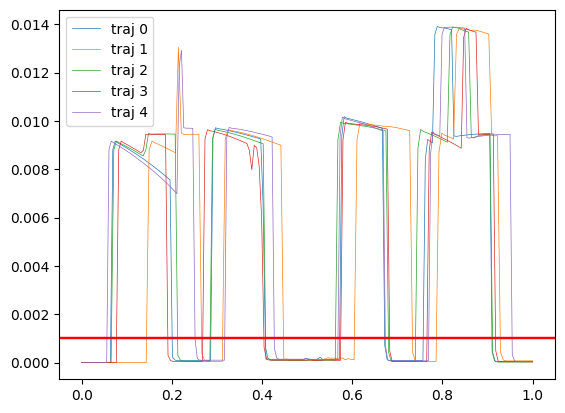

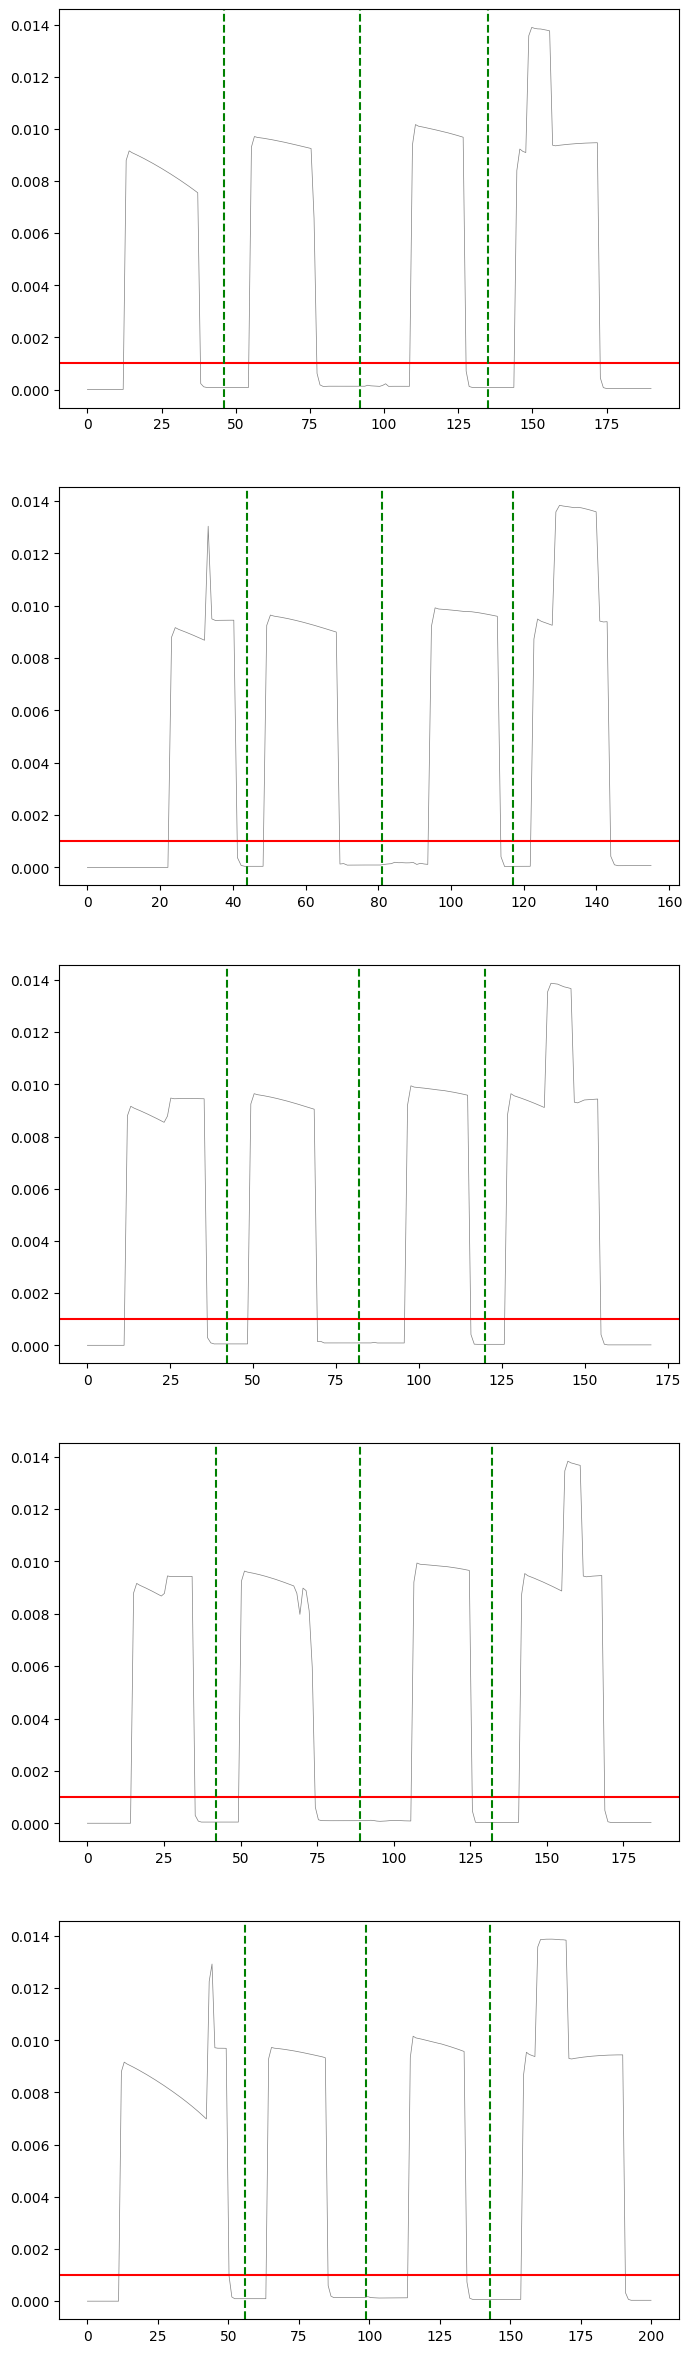

2025-08-05 19:27:38.231 | INFO     |  Creating segement of demos.
2025-08-05 19:27:38.234 | INFO     |  Subsampling to length 46 using strategy mean-length.
2025-08-05 19:27:38.235 | INFO     |  Creating segement of demos.
2025-08-05 19:27:38.238 | INFO     |  Subsampling to length 42 using strategy mean-length.
2025-08-05 19:27:38.239 | INFO     |  Creating segement of demos.
2025-08-05 19:27:38.243 | INFO     |  Subsampling to length 40 using strategy mean-length.
2025-08-05 19:27:38.244 | INFO     |  Creating segement of demos.
2025-08-05 19:27:38.248 | INFO     |  Subsampling to length 50 using strategy mean-length.
2025-08-05 19:27:38.249 | INFO     |  ... created 4 segments
2025-08-05 19:27:38.249 | INFO     |    Fitting candidate frame 1/10
2025-08-05 19:27:38.249 | INFO     |    Creating partial frame view of demos.
2025-08-05 19:27:38.256 | INFO     |    Changing number of components to 5


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:38.530 | INFO     |    Fitting candidate frame 2/10
2025-08-05 19:27:38.531 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:38.768 | INFO     |    Fitting candidate frame 3/10
2025-08-05 19:27:38.768 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:39.056 | INFO     |    Fitting candidate frame 4/10
2025-08-05 19:27:39.057 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:39.295 | INFO     |    Fitting candidate frame 5/10
2025-08-05 19:27:39.295 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:39.584 | INFO     |    Fitting candidate frame 6/10
2025-08-05 19:27:39.584 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:39.851 | INFO     |    Fitting candidate frame 7/10
2025-08-05 19:27:39.851 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:40.080 | INFO     |    Fitting candidate frame 8/10
2025-08-05 19:27:40.081 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:40.362 | INFO     |    Fitting candidate frame 9/10
2025-08-05 19:27:40.362 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:40.607 | INFO     |    Fitting candidate frame 10/10
2025-08-05 19:27:40.607 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:40.883 | INFO     |  ee_init    score (rel):     -0 (0.217)
2025-08-05 19:27:40.883 | INFO     |  obj000     score (rel):     -0 (0.217)
2025-08-05 19:27:40.883 | INFO     |  obj001     score (rel):     -0 (0.217)
2025-08-05 19:27:40.883 | INFO     |  obj002     score (rel):     -0 (0.217)
2025-08-05 19:27:40.883 | INFO     |  obj003     score (rel):     -0 (0.217)
2025-08-05 19:27:40.883 | INFO     |  obj004     score (rel):     -0 (0.217)
2025-08-05 19:27:40.883 | INFO     |  obj005     score (rel):     -0 (0.217)
2025-08-05 19:27:40.883 | INFO     |  obj006     score (rel):     -0 (0.002)
2025-08-05 19:27:40.883 | INFO     |  obj008     score (rel):     -0 (0.001)
2025-08-05 19:27:40.884 | INFO     |  Creating partial frame view of demos.
2025-08-05 19:27:40.963 | INFO     |    Fitting candidate frame 1/10
2025-08-05 19:27:40.963 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:41.177 | INFO     |    Fitting candidate frame 2/10
2025-08-05 19:27:41.177 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:41.421 | INFO     |    Fitting candidate frame 3/10
2025-08-05 19:27:41.422 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:41.638 | INFO     |    Fitting candidate frame 4/10
2025-08-05 19:27:41.639 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:41.885 | INFO     |    Fitting candidate frame 5/10
2025-08-05 19:27:41.885 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:42.080 | INFO     |    Fitting candidate frame 6/10
2025-08-05 19:27:42.081 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:42.286 | INFO     |    Fitting candidate frame 7/10
2025-08-05 19:27:42.287 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:42.528 | INFO     |    Fitting candidate frame 8/10
2025-08-05 19:27:42.529 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:42.786 | INFO     |    Fitting candidate frame 9/10
2025-08-05 19:27:42.786 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:42.983 | INFO     |    Fitting candidate frame 10/10
2025-08-05 19:27:42.983 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:43.175 | INFO     |  Creating partial frame view of demos.
2025-08-05 19:27:43.244 | INFO     |    Fitting candidate frame 1/10
2025-08-05 19:27:43.245 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:43.476 | INFO     |    Fitting candidate frame 2/10
2025-08-05 19:27:43.477 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:43.723 | INFO     |    Fitting candidate frame 3/10
2025-08-05 19:27:43.724 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:43.964 | INFO     |    Fitting candidate frame 4/10
2025-08-05 19:27:43.964 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:44.248 | INFO     |    Fitting candidate frame 5/10
2025-08-05 19:27:44.248 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:44.496 | INFO     |    Fitting candidate frame 6/10
2025-08-05 19:27:44.496 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:44.734 | INFO     |    Fitting candidate frame 7/10
2025-08-05 19:27:44.734 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:45.056 | INFO     |    Fitting candidate frame 8/10
2025-08-05 19:27:45.056 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:45.293 | INFO     |    Fitting candidate frame 9/10
2025-08-05 19:27:45.293 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:45.471 | INFO     |    Fitting candidate frame 10/10
2025-08-05 19:27:45.471 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 19:27:45.678 | INFO     |  ee_init    score (rel):     -0 (0.087)
2025-08-05 19:27:45.678 | INFO     |  obj000     score (rel):     -0 (0.087)
2025-08-05 19:27:45.678 | INFO     |  obj001     score (rel):     -0 (0.087)
2025-08-05 19:27:45.678 | INFO     |  obj002     score (rel):     -0 (0.087)
2025-08-05 19:27:45.678 | INFO     |  obj003     score (rel):     -0 (0.087)
2025-08-05 19:27:45.678 | INFO     |  obj004     score (rel):     -0 (0.087)
2025-08-05 19:27:45.678 | INFO     |  obj005     score (rel):     -0 (0.087)
2025-08-05 19:27:45.679 | INFO     |  Creating partial frame view of demos.
2025-08-05 19:27:45.799 | INFO     |    Fitting candidate frame 1/10
2025-08-05 19:27:45.800 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:46.058 | INFO     |    Fitting candidate frame 2/10
2025-08-05 19:27:46.058 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:46.296 | INFO     |    Fitting candidate frame 3/10
2025-08-05 19:27:46.296 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:46.571 | INFO     |    Fitting candidate frame 4/10
2025-08-05 19:27:46.571 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:46.837 | INFO     |    Fitting candidate frame 5/10
2025-08-05 19:27:46.838 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:47.126 | INFO     |    Fitting candidate frame 6/10
2025-08-05 19:27:47.127 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:47.360 | INFO     |    Fitting candidate frame 7/10
2025-08-05 19:27:47.361 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:47.630 | INFO     |    Fitting candidate frame 8/10
2025-08-05 19:27:47.630 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:47.931 | INFO     |    Fitting candidate frame 9/10
2025-08-05 19:27:47.932 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:48.182 | INFO     |    Fitting candidate frame 10/10
2025-08-05 19:27:48.182 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:27:48.493 | INFO     |  ee_init    score (rel):     -0 (0.249)
2025-08-05 19:27:48.494 | INFO     |  obj000     score (rel):     -0 (0.249)
2025-08-05 19:27:48.494 | INFO     |  obj001     score (rel):     -0 (0.249)
2025-08-05 19:27:48.494 | INFO     |  obj002     score (rel):     -0 (0.249)
2025-08-05 19:27:48.494 | INFO     |  obj003     score (rel):     -0 (0.249)
2025-08-05 19:27:48.494 | INFO     |  obj004     score (rel):     -0 (0.249)
2025-08-05 19:27:48.494 | INFO     |  obj005     score (rel):     -0 (0.249)
2025-08-05 19:27:48.494 | INFO     |  obj006     score (rel):     -0 (0.006)
2025-08-05 19:27:48.495 | INFO     |  Creating partial frame view of demos.
2025-08-05 19:27:48.582 | INFO     |  Segmented trajs into 4 segments
2025-08-05 19:27:48.587 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.141991 -0.141991 -0.141991 -0.141991 -0.141991 -0.141991   
Segment 1 -0.047448 -0.047447 -0.04

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

((array([[3.40e+073, 3.99e+073, 4.47e+073, ..., 1.09e-262, 3.01e-263,
          7.94e-264],
         [4.59e+071, 8.24e+071, 1.41e+072, ..., 8.14e+004, 5.82e+004,
          3.96e+004],
         [1.02e+068, 2.36e+068, 5.17e+068, ..., 2.46e+044, 1.54e+044,
          9.16e+043],
         [6.87e+056, 2.13e+057, 6.24e+057, ..., 5.23e+067, 4.47e+067,
          3.61e+067],
         [6.08e+022, 3.73e+023, 2.18e+024, ..., 4.86e+072, 4.46e+072,
          3.88e+072]]),
  array([[7.36e+72, 8.91e+72, 1.03e+73, 1.13e+73, 1.20e+73, 1.20e+73,
          1.15e+73, 1.06e+73, 9.26e+72, 8.53e+72, 3.91e+72, 8.82e+71,
          9.80e+70, 5.39e+69, 1.47e+68, 2.01e+66, 4.42e+61, 7.54e+58,
          6.54e+55, 2.91e+52, 6.65e+48, 7.91e+44, 4.90e+40, 1.59e+36,
          2.73e+31, 2.49e+26, 2.27e+15, 3.16e+09, 2.82e+05, 7.71e+05,
          1.27e+06, 1.90e+06, 2.71e+06, 3.76e+06, 4.95e+06, 6.23e+06,
          8.76e+06, 1.00e+07, 1.09e+07, 1.13e+07, 1.12e+07, 1.06e+07,
          8.09e+72, 9.39e+72, 1.04e+73, 1.10e+73

In [42]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-05 19:27:54.583 | INFO     |  Did not specify time_based, deciding automatically.


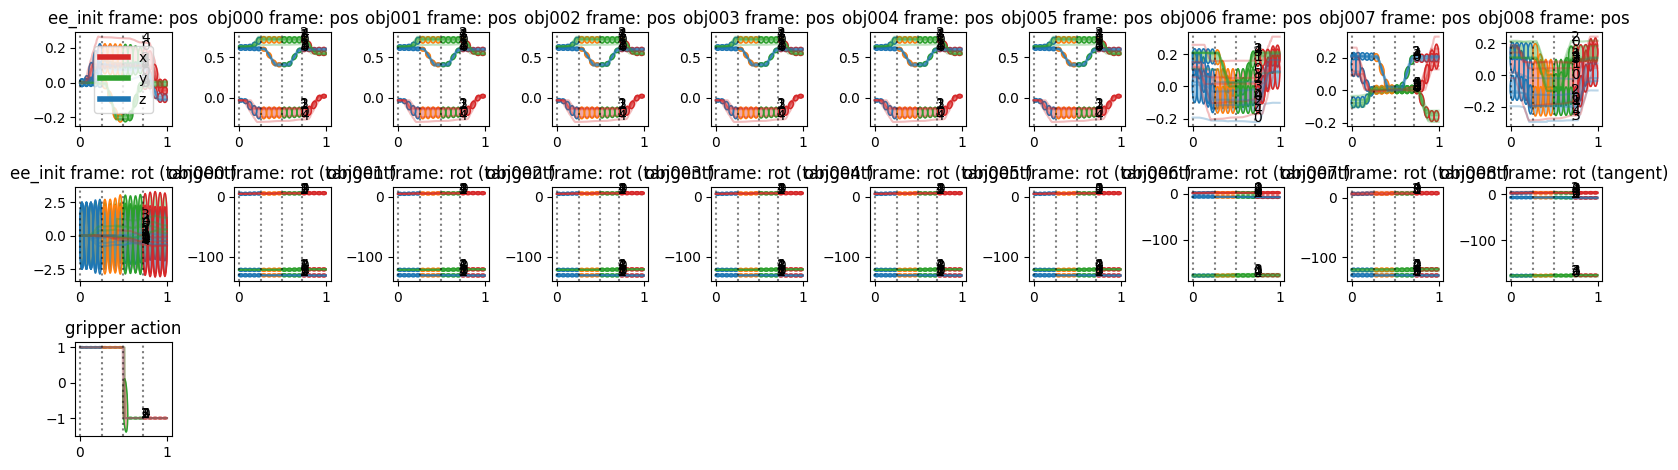

In [43]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [44]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-05 19:28:07.570 | INFO     |  Fitting AutoTPGMM


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.38e-076, 1.71e-069, 3.17e-062, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 2.38e-076, 1.71e-069, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 0.00e+000, 9.92e-229, ..., 6.99e-190, 4.11e-232,
          0.00e+000],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 9.97e-001, 8.89e-001, 5.44e-002, 1.31e-006,
          5.16e-016, 1.43e-031, 9.78e-055, 2.47e-087, 6.91e-142, 1.15e-209,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
      

2025-08-05 22:03:25.081 | INFO     |  Did not specify time_based, deciding automatically.


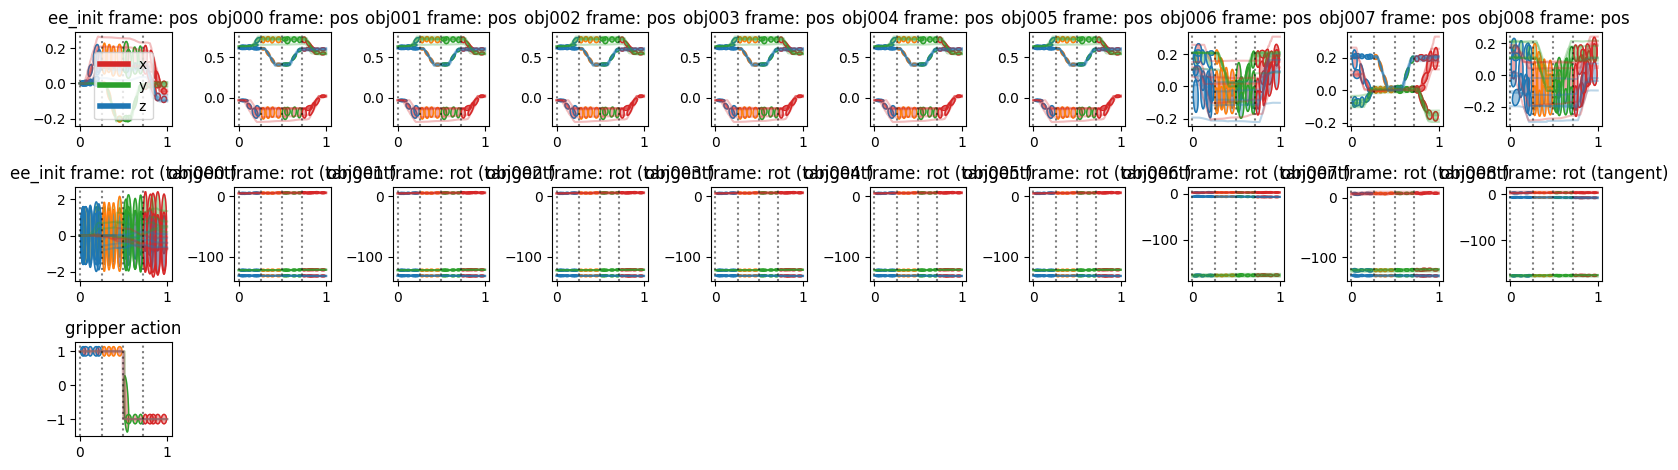

In [52]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

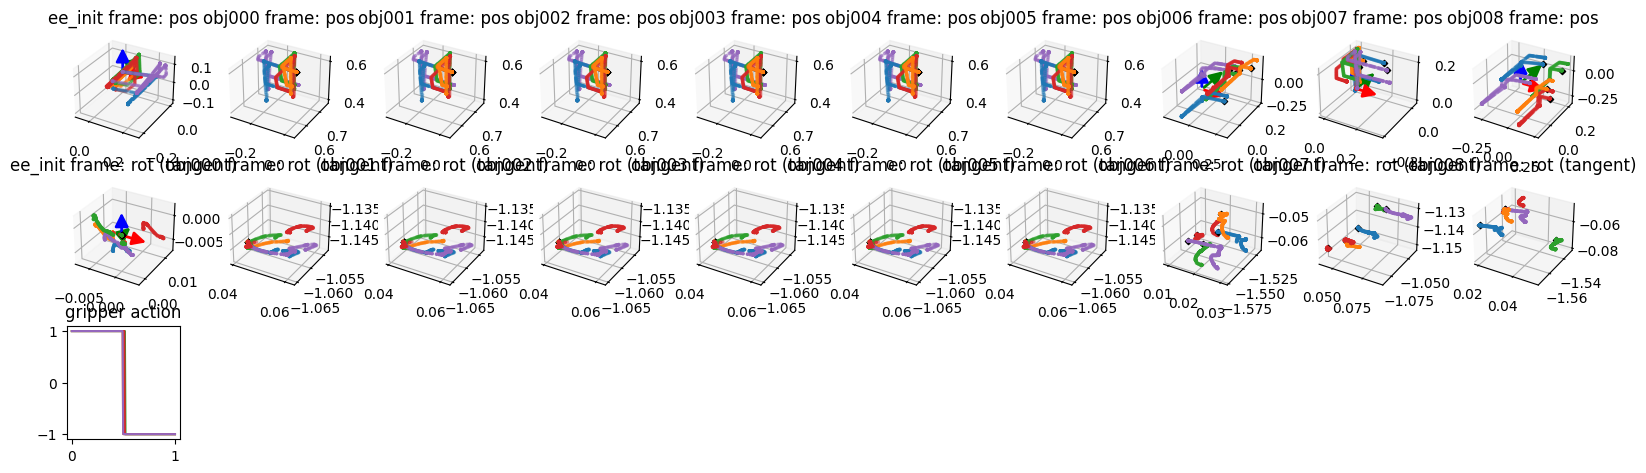

In [46]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

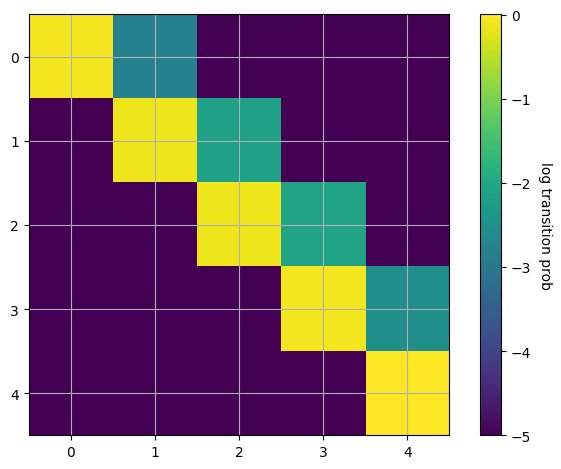

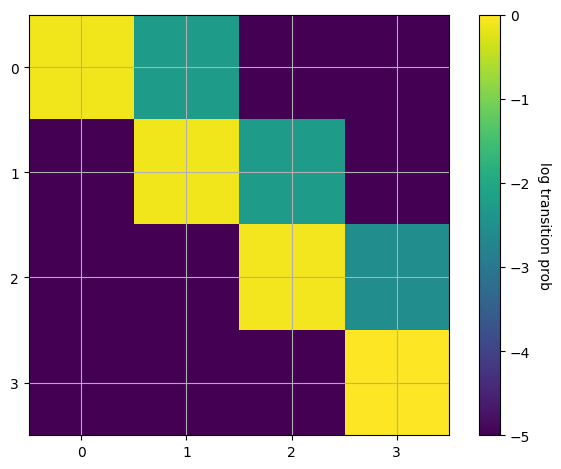

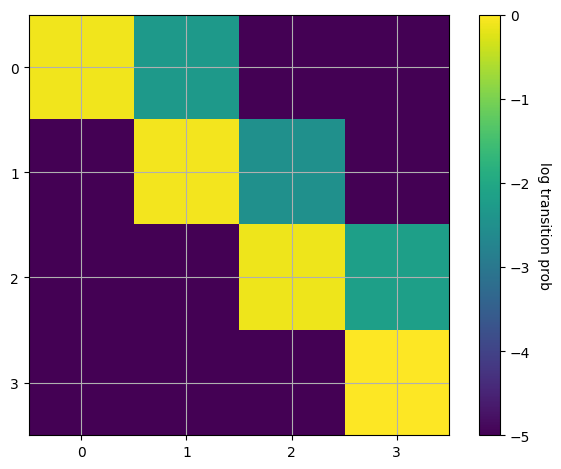

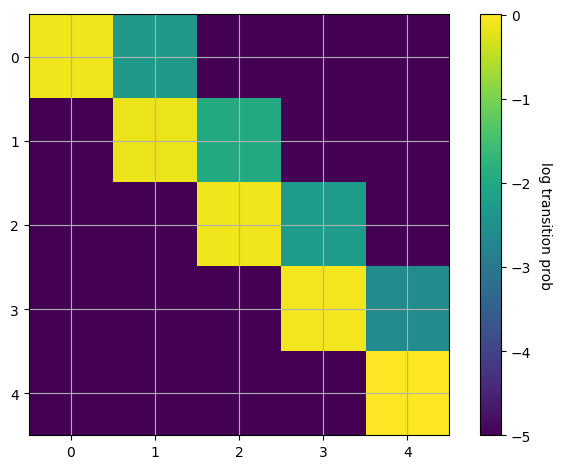

In [47]:
atpgmm.plot_hmm_transition_matrix()

In [48]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

In [49]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-05 19:34:21.384 | INFO     |  Caculated segment transition probabilities: (array([[0.79]]), array([[0.64]]), array([[0.86]]))
2025-08-05 19:34:21.384 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:34:22.756 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:34:23.906 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 19:34:24.857 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

GMR:   0%|          | 0/5 [00:00<?, ?it/s]

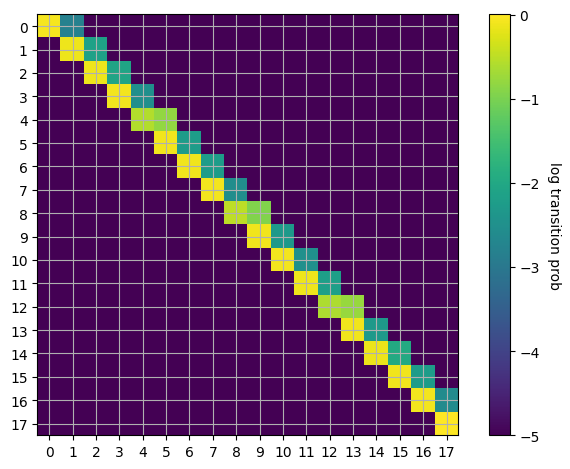

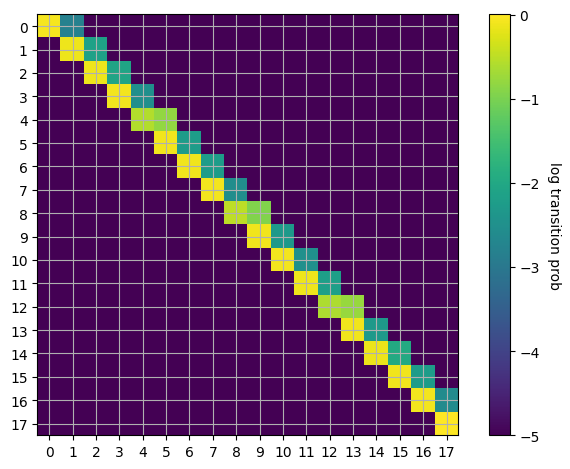

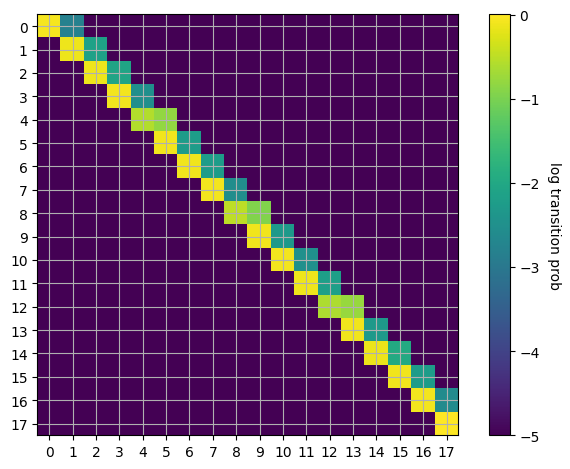

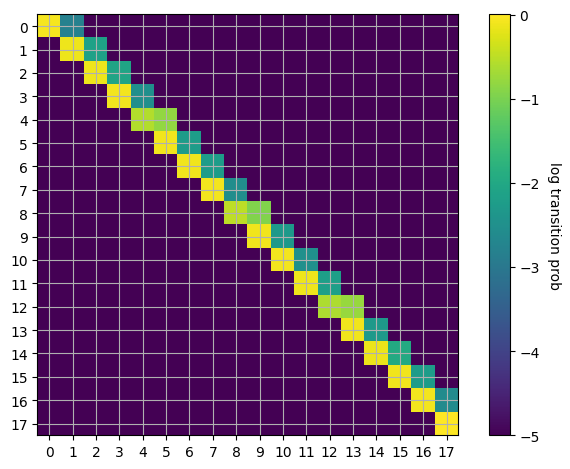

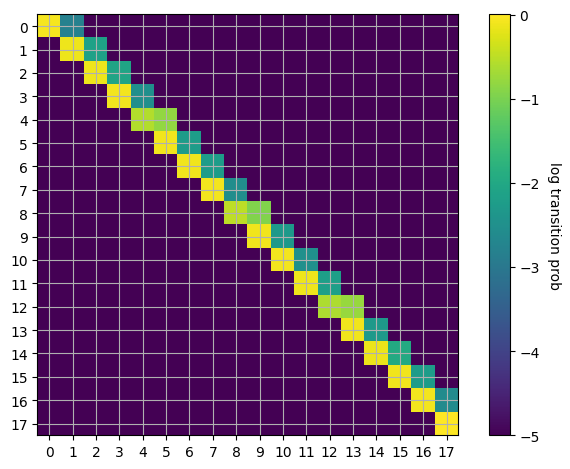

In [50]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-05 19:34:55.773 | INFO     |  Taking frame origins from demos.


IndexError: tuple index out of range

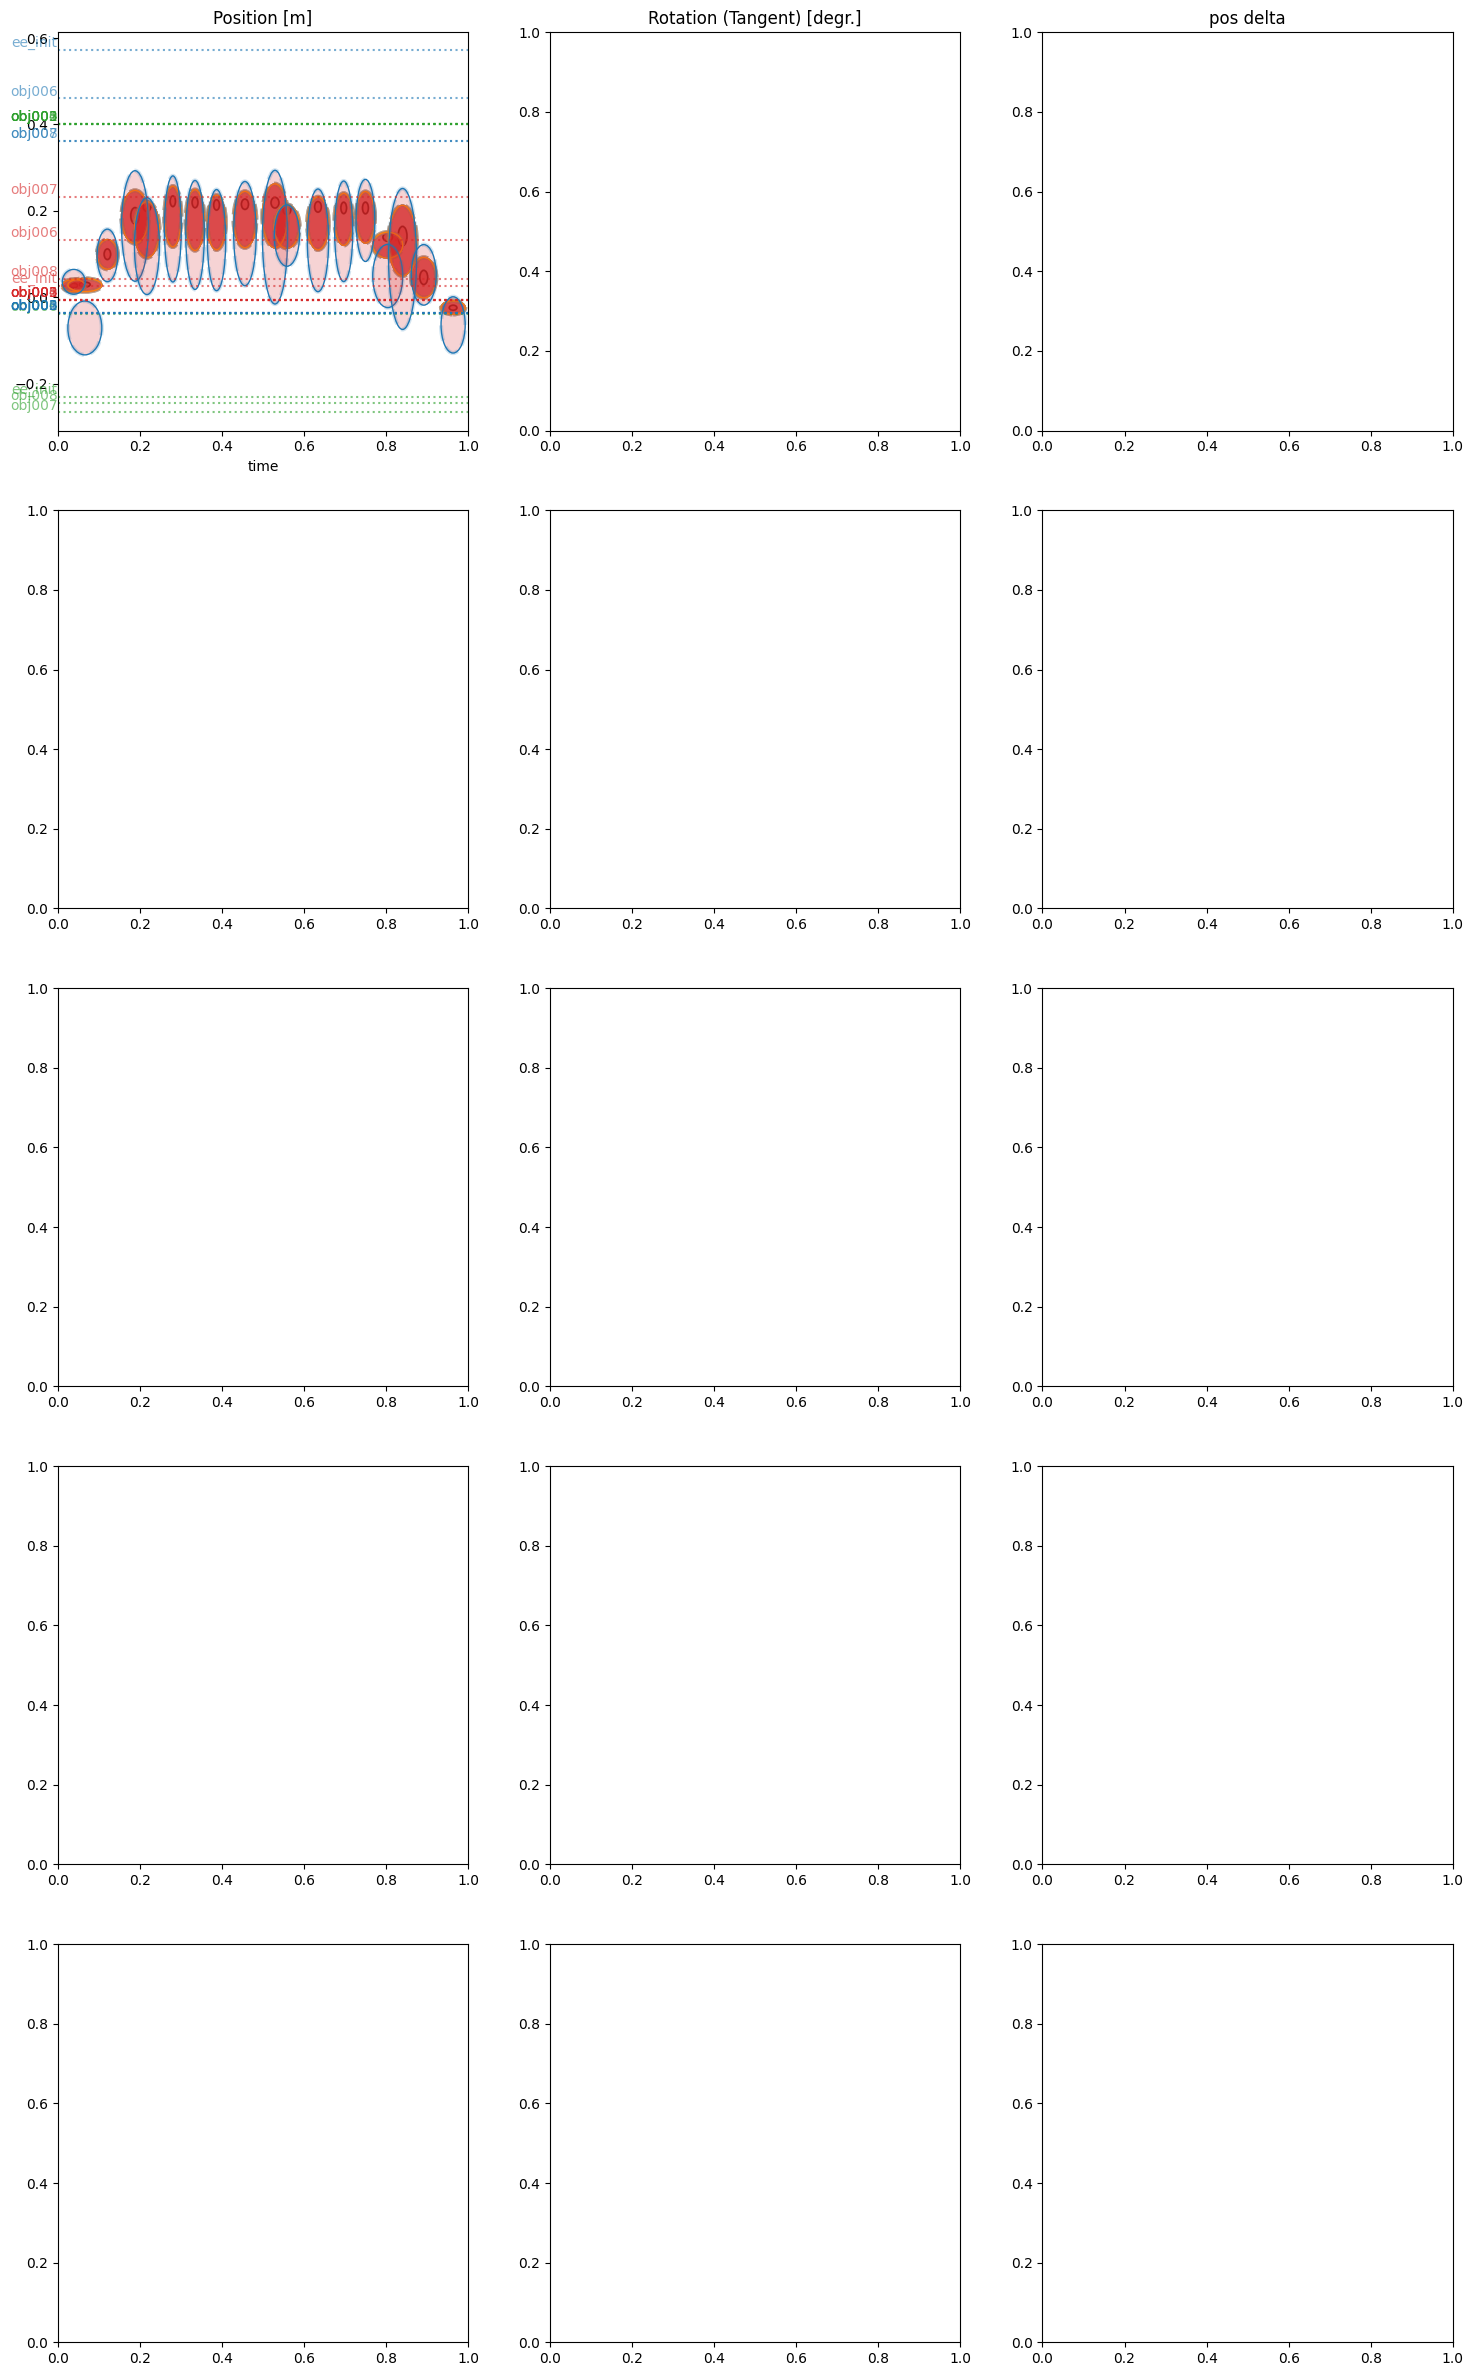

In [51]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range